# Decoding in the time domain
Based on the paper from [Loula, Varoquaux, & Thirion (2017)](http://www.sciencedirect.com/science/article/pii/S1053811917306651?via%3Dihub).

In [1]:
import numpy as np
from nistats.design_matrix import make_design_matrix
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
TR = 2
N_stim = 15
ISI_values = [4, 6, 8]

trials = np.random.permutation(np.repeat(['A', 'B', 'C'], repeats=N_stim))
ISIs = np.random.permutation(np.repeat(ISI_values, repeats=N_stim))
durations = np.ones(trials.size) * 2
onsets = [np.sum(durations[:(i + 1)] + ISIs[:(i + 1)]) for i in range(trials.size)]

N_vols = int(onsets[-1] / 2 + 2)
frame_times = np.arange(N_vols) * TR

paradigm = pd.DataFrame(dict(
    trial_type=trials,
    onset=onsets,
    duration=durations
))

paradigm

,duration,onset,trial_type
0,2.0,8.0,A
1,2.0,16.0,B
2,2.0,26.0,C
3,2.0,36.0,A
4,2.0,46.0,C
5,2.0,52.0,B
6,2.0,58.0,A
7,2.0,68.0,C
8,2.0,78.0,B
9,2.0,88.0,B


In [10]:
weights = np.array([1, 2, 1.5])
Xruns = []
yruns = []
N_runs = 5

for i in range(N_runs):
    Xruns.append(make_design_matrix(
        paradigm=paradigm,
        frame_times=frame_times, hrf_model='glover',
        drift_model=None, period_cut=128
    ))
    Xruns[i] = Xruns[i].values[:, :-1]
    yruns.append(np.sum((Xruns[i] * weights + np.random.normal(0, 1, Xruns[i].shape)/2), axis=1))

X = np.vstack(Xruns)
y = np.concatenate(yruns)
run_id = np.repeat(np.arange(N_runs), repeats=N_vols)

print(X.shape)
print(y.shape)
print(run_id.shape)

(910, 3)
(910,)
(910,)


In [11]:
from sklearn.model_selection import LeavePGroupsOut
from sklearn.linear_model import RidgeCV

lpgo = LeavePGroupsOut(n_groups=1)
clf = RidgeCV()

preds = np.zeros((N_vols, X.shape[1], N_runs))
for i, (train_idx, test_idx) in enumerate(lpgo.split(X, y, run_id)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    clf.fit(y_train[:, np.newaxis], X_train)
    preds[:, :, i] = clf.predict(y_test[:, np.newaxis])

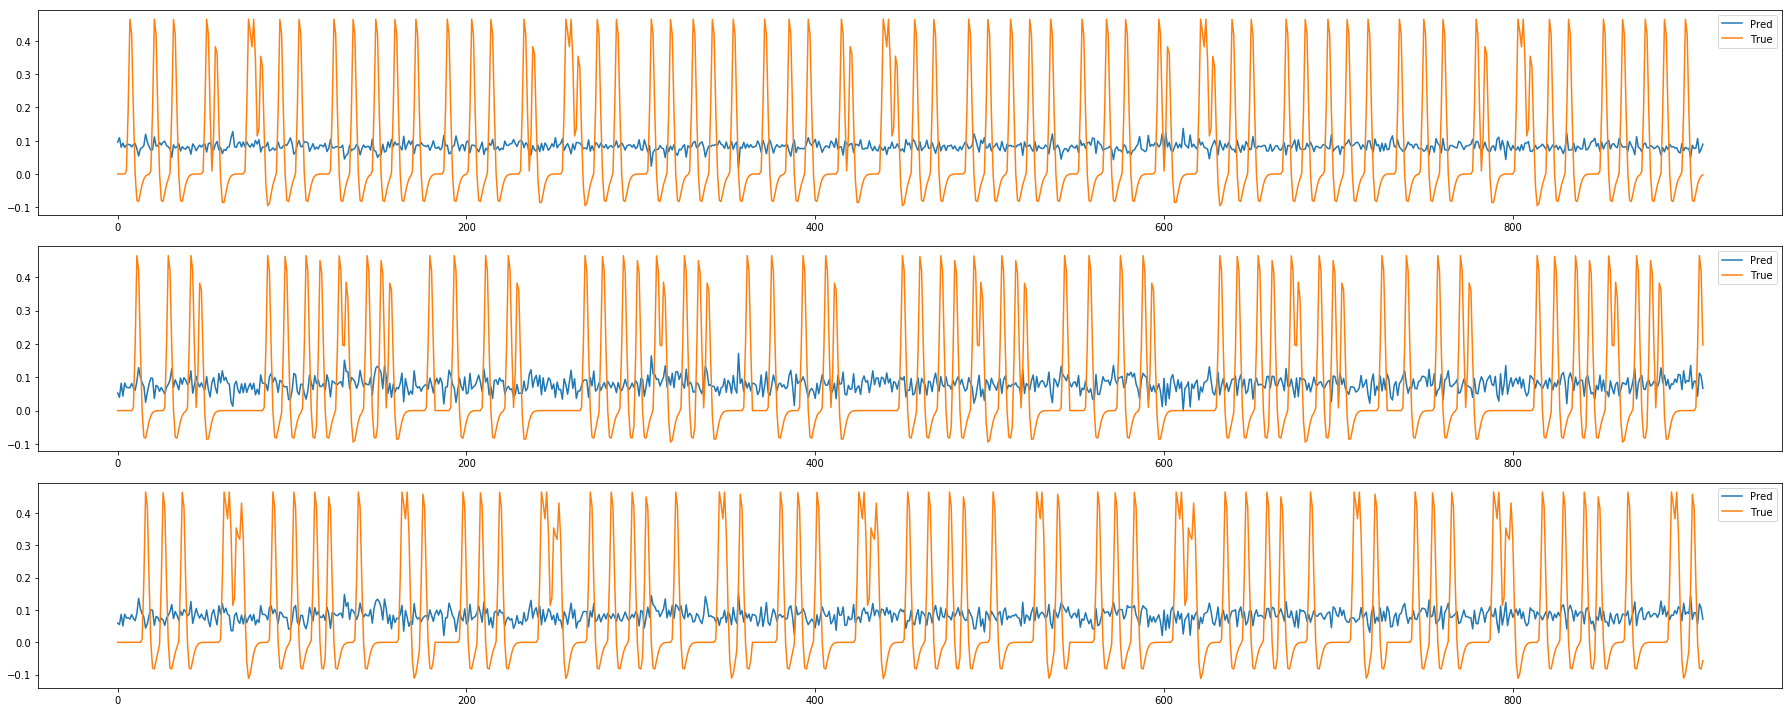

In [12]:
plt.figure(figsize=(25, 10))

plt.subplot(3, 1, 1)
plt.plot(preds[:, 0, :].ravel())
plt.plot(X[:, 0])
plt.legend(['Pred', 'True'])

plt.subplot(3, 1, 2)
plt.plot(preds[:, 1, :].ravel())
plt.plot(X[:, 1])
plt.legend(['Pred', 'True'])

plt.subplot(3, 1, 3)
plt.plot(preds[:, 2, :].ravel())
plt.plot(X[:, 2])
plt.legend(['Pred', 'True'])
plt.tight_layout()
plt.show()

In [13]:
from sklearn.linear_model import LogisticRegression
clf_t = LogisticRegression()

window = 15

stims = np.zeros(N_vols)
stims[(paradigm[paradigm.trial_type == 'A'].onset.values / 2).astype(int)] = 1
stims[(paradigm[paradigm.trial_type == 'B'].onset.values / 2).astype(int)] = 2
stims[(paradigm[paradigm.trial_type == 'C'].onset.values / 2).astype(int)] = 3
stims = np.tile(stims, 5)

scores = np.zeros(len(range(y.size - 1)))
for i in range(y.size - 1):
    end = (i + window)
    if end > y.size:
        end = (i + y.size - i)
    X_test = preds.reshape(-2, preds.shape[-2])
    X_test = X_test[i:end, :]
    stims_test = stims[i:end]
    clf_t.fit(X_test, stims_test)
    scores[i] = clf_t.score(X_test, stims_test)
scores.mean()

0.75168997363716816

## GLM approach

In [14]:
paradigm_st = pd.DataFrame(dict(
    trial_type=[t + '_%i' % i for i, t in enumerate(trials)],
    onset=onsets,
    duration=durations
))

w = dict(A=1, B=2, C=1.5)
weights = np.array([w[t[0]] for t in paradigm_st.trial_type])

Xruns = []
yruns = []
N_runs = 5

for i in range(N_runs):
    Xruns.append(make_design_matrix(
        paradigm=paradigm_st,
        frame_times=frame_times, hrf_model='glover',
        drift_model=None, period_cut=128
    ))
    Xruns[i] = Xruns[i].values[:, :-1]
    yruns.append(np.sum((Xruns[i] * weights + np.random.normal(0, 1, Xruns[i].shape)/100), axis=1))

In [15]:
betas = []
for i in range(N_runs):
    betas.append(np.linalg.lstsq(Xruns[i], yruns[i])[0])
betas = np.concatenate(betas)[:, np.newaxis]

encode = dict(A=1, B=2, C=3)
ys = np.array([encode[t[0]] for t in paradigm_st.trial_type])
ys = np.tile(ys, N_runs)

from sklearn.model_selection import cross_val_score

groups = np.repeat(np.arange(N_runs), 45)
cross_val_score(clf_t, X=betas, y=ys, groups=groups, cv=5).mean()

0.77333333333333332